<a href="https://colab.research.google.com/github/BdsKlause/BdsKlause/blob/main/aurum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk
!pip install pandas

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import files

uploaded = files.upload()  # This opens a file upload dialog


Saving sentimentdataset_with_scores.csv to sentimentdataset_with_scores.csv


In [ ]:
!ls /content/


drive  sample_data  sentimentdataset_with_scores.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/aurum')
print("Current Directory:", os.getcwd())


Current Directory: /content/drive/My Drive/aurum


## Data loading

### Subtask:
Load the dataset.


In [ ]:
import pandas as pd
import os


df = pd.read_csv('/content/drive/My Drive/dataset/aurum/sentimentdataset_with_scores.csv')

# 2. Get the current working directory
current_directory = os.getcwd()

# 3. Define the file path for saving in the current directory
file_path = os.path.join(current_directory, 'sentimentdataset_with_scores.csv')

# 4. Save the DataFrame to the current directory as a CSV file
df.to_csv(file_path, index=False)  # index=False prevents saving the index

print(f"Dataset saved to: {file_path}")

# 5. Now, you can load it from the current directory (optional)
df_loaded = pd.read_csv('sentimentdataset_with_scores.csv')
display(df_loaded.head()) #Display the first few rows to verify

Dataset saved to: /content/drive/My Drive/aurum/sentimentdataset_with_scores.csv


,unnamed,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,1,Enjoying a beautiful day at the park! ...,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,2,Traffic was terrible this morning. ...,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,3,Just finished an amazing workout! ?? ...,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,4,Excited about the upcoming weekend getaway! ...,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,5,Trying out a new recipe for dinner tonight. ...,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


## Data exploration

### Subtask:
Explore the loaded dataset to understand its characteristics.


Shape of the DataFrame: (732, 15)

Data Types:
unnamed                 int64
Text                   object
Timestamp              object
User                   object
Platform               object
Hashtags               object
Retweets                int64
Likes                   int64
Country                object
Year                    int64
Month                   int64
Day                     int64
Hour                    int64
sentiment_score       float64
sentiment_category     object
dtype: object

Missing Values:
unnamed               0
Text                  0
Timestamp             0
User                  0
Platform              0
Hashtags              0
Retweets              0
Likes                 0
Country               0
Year                  0
Month                 0
Day                   0
Hour                  0
sentiment_score       0
sentiment_category    0
dtype: int64

Descriptive statistics for 'sentiment_score':
count    732.000000
mean       0.255119
std        0

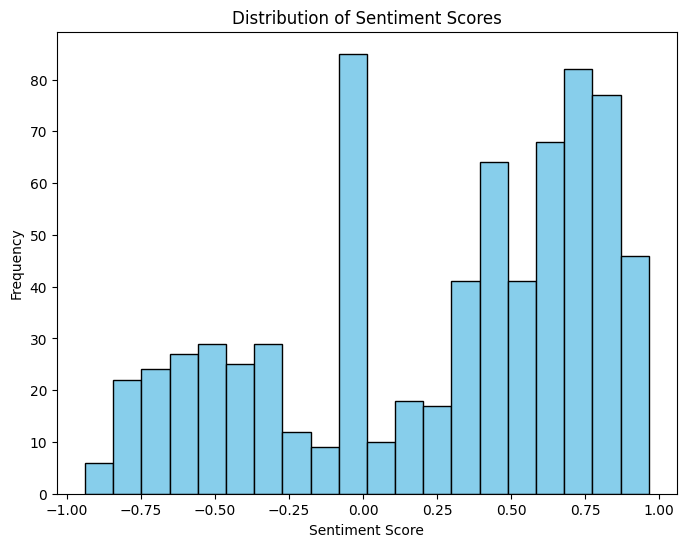

In [ ]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine data types
print("\nData Types:")
print(df.dtypes)

# Identify the text column (assuming it's named 'Text' or similar)
text_column = 'Text'  # Replace with the actual column name if different

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Analyze the distribution of 'sentiment_score'
print("\nDescriptive statistics for 'sentiment_score':")
print(df['sentiment_score'].describe())

# Analyze the distribution of 'sentiment_category'
print("\nUnique values and counts in 'sentiment_category':")
print(df['sentiment_category'].value_counts())

# Basic visualization (histogram for sentiment score)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

## Data cleaning

### Subtask:
Clean the text data in the 'Text' column of the DataFrame `df`.


In [ ]:
import re

# Remove irrelevant characters, handle missing values, and convert to lowercase
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
    elif pd.isna(text):
        text = ""  # Handle missing values with an empty string
    return text

df['Text'] = df['Text'].apply(clean_text)
display(df.head())

,unnamed,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,1,enjoying a beautiful day at the park ...,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,2,traffic was terrible this morning ...,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,3,just finished an amazing workout,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,4,excited about the upcoming weekend getaway ...,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,5,trying out a new recipe for dinner tonight ...,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


## Data preparation

### Subtask:
Prepare the data for modeling by splitting it into training, validation, and testing sets, and performing necessary text transformations for each model (Logistic Regression, LSTM, and Roberta).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define features (X) and target variables (y)
X = df['Text']
y_score = df['sentiment_score']
y_category = df['sentiment_category']

# Split data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train_score, y_temp_score, y_train_category, y_temp_category = train_test_split(
    X, y_score, y_category, test_size=0.2, random_state=42
)
X_val, X_test, y_val_score, y_test_score, y_val_category, y_test_category = train_test_split(
    X_temp, y_temp_score, y_temp_category, test_size=0.5, random_state=42
)

# Logistic Regression Preparation: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# LSTM and Roberta Preparation: Tokenization and Sequencing
max_sequence_length = 100  # Adjust as needed
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Limit vocabulary size
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert target variables to numpy arrays for LSTM and Roberta
y_train_score = np.array(y_train_score)
y_val_score = np.array(y_val_score)
y_test_score = np.array(y_test_score)

#For simplicity, convert sentiment category to numerical representation for LSTM and Roberta
category_mapping = {'Positive': 2, 'Negative': 1, 'Neutral': 1}
y_train_category = np.array([category_mapping[category] for category in y_train_category])
y_val_category = np.array([category_mapping[category] for category in y_val_category])
y_test_category = np.array([category_mapping[category] for category in y_test_category])

## Model training

### Subtask:
Train a logistic Regression model to predict sentiment scores.


In [ ]:
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

# Initialize and train a Logistic Regression model
# Convert text to numerical feature vectors using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
# Initialize and train logistic regression model
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear')  # Use 'ovr' for multi-class classification
log_reg.fit(X_train_tfidf, y_train_category) # Changed y_train to y_train_category, assuming you're predicting sentiment category

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr', solver='liblinear')

## Model evaluation

### Subtask:
Evaluate the performance of the trained Logistic Regression model.


In [ ]:
# Predict on validation set
y_pred = log_reg.predict(X_val_tfidf)

# Import accuracy_score
from sklearn.metrics import accuracy_score # Added this import

# Calculate accuracy
accuracy = accuracy_score(y_val_category, y_pred) # Changed y_val to y_val_category
print(f"Accuracy: {accuracy:.4f}")

# Import classification_report and confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix # Added this import

# Display classification report
print("\nClassification Report:")
print(classification_report(y_val_category, y_pred)) # Changed y_val to y_val_category

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_category, y_pred)) # Changed y_val to y_val_category

Accuracy: 0.6301

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        44
           1       1.00      0.09      0.16        23
           2       0.00      0.00      0.00         6

    accuracy                           0.63        73
   macro avg       0.54      0.36      0.31        73
weighted avg       0.69      0.63      0.51        73


Confusion Matrix:
[[44  0  0]
 [21  2  0]
 [ 6  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#test the model on new texts
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])  # Convert text to TF-IDF features
    pred = log_reg.predict(text_tfidf)[0]  # Predict sentiment class

    sentiment_labels = {1: "Negative", 0: "Neutral", 2: "Positive"}
    print(f"Predicted Sentiment: {sentiment_labels[pred]}")

# Example Predictions
predict_sentiment("I love this product! It's amazing.")
predict_sentiment("This is the worst experience ever.")
predict_sentiment("The service was okay, not great but not bad.")
predict_sentiment("This must be the worse salad I've tasted. ")

Predicted Sentiment: Neutral
Predicted Sentiment: Neutral
Predicted Sentiment: Neutral
Predicted Sentiment: Neutral


## Model training

### Subtask:
Train an LSTM model to predict sentiment scores.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Define the LSTM model
model = Sequential([
    Embedding(5000, 128, input_length=100),  # Embedding layer
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),  # LSTM with dropout
    Dense(32, activation='relu'),  # Extra dense layer for feature extraction
    Dropout(0.2),
    Dense(1, activation='linear')  # Regression output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_seq, y_train_score,
                    epochs=10, batch_size=32,
                    validation_data=(X_val_seq, y_val_score))

# Save the model (optional)
model.save('lstm_sentiment_model.h5')


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.2893 - mae: 0.4708 - val_loss: 0.3201 - val_mae: 0.4873
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.2780 - mae: 0.4634 - val_loss: 0.3366 - val_mae: 0.4770
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.2772 - mae: 0.4553 - val_loss: 0.3183 - val_mae: 0.4895
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.2735 - mae: 0.4508 - val_loss: 0.3174 - val_mae: 0.4910
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.2713 - mae: 0.4550 - val_loss: 0.3215 - val_mae: 0.4858
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.2740 - mae: 0.4581 - val_loss: 0.3255 - val_mae: 0.4825
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.2589 - mae: 0.4406 - val_loss: 0.3202 - val_mae: 0.4872
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.2672 - mae: 0.4497 - val_loss: 0.3206 - val_mae: 0.4868
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.2715 

**# New Section
# LSTM evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict sentiment scores on the validation set
y_pred_score = model.predict(X_val_seq)

# Convert predictions to a 1D array
y_pred_score = y_pred_score.flatten()

# Compute evaluation metrics
mse = mean_squared_error(y_val_score, y_pred_score)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_score, y_pred_score)
r2 = r2_score(y_val_score, y_pred_score)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Mean Squared Error (MSE): 0.3315
Root Mean Squared Error (RMSE): 0.5758
Mean Absolute Error (MAE): 0.4792
R-squared (R2) Score: -0.0509


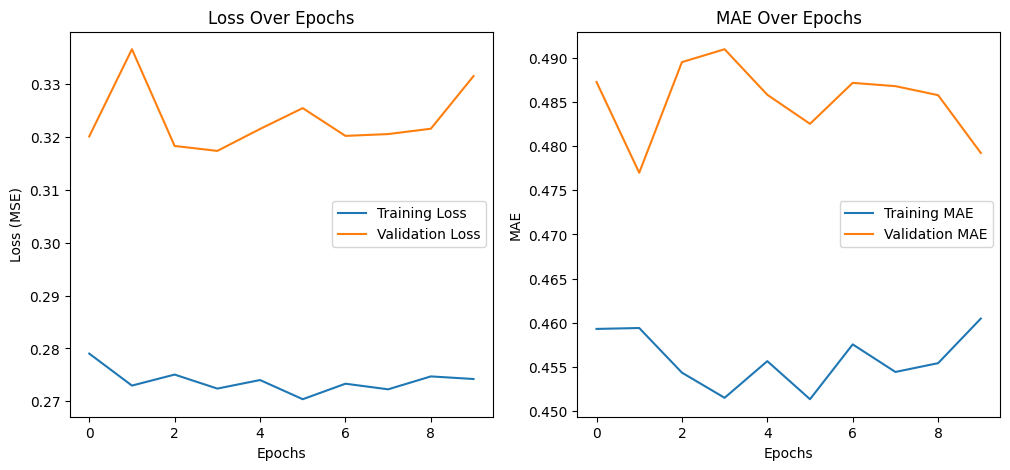

In [ ]:
# Visualize model performance

# Plot training history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Loss Over Epochs')

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE Over Epochs')

plt.show()


In [ ]:
#testing the model on new texts

def predict_sentiment(text):
    # Convert text to sequence
    seq = tokenizer.texts_to_sequences([text])
    seq_padded = pad_sequences(seq, maxlen=100, padding='post')

    # Predict sentiment score
    score = model.predict(seq_padded)[0][0]

    # Print results
    print(f"Predicted Sentiment Score: {score:.4f}")
    return score

# Example Predictions
predict_sentiment("I love this product! It's amazing.")
predict_sentiment("This is the worst experience ever.")
predict_sentiment("The service was okay, not great but not bad.")
predict_sentiment("This must be the worsad salad I've tasted. ")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Sentiment Score: 0.3020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Sentiment Score: 0.3020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Sentiment Score: 0.3020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Sentiment Score: 0.3020


0.3019639

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Download necessary NLP tools
nltk.download('stopwords')
nltk.download('wordnet')

# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Load dataset
df = pd.read_csv("sentimentdataset_with_scores.csv")
# Change 'text' to 'Text' to match the actual column name
df['Text'] = df['Text'].apply(clean_text)

# Convert sentiment to numerical values (-1, 0, 1)
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
# Assuming 'sentiment' column exists, if not, adjust accordingly
df['sentiment'] = df['sentiment_category'].map(sentiment_mapping)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['sentiment'], test_size=0.2, random_state=42)

# Tokenization and Padding
max_words = 5000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# LSTM Model with Bidirectional Layer
model = Sequential([
    Embedding(max_words, 128, input_length=max_length),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Regression output
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_data=(X_val_seq, y_val))

# Model Evaluation
y_pred_score = model.predict(X_val_seq).flatten()

mse = mean_squared_error(y_val, y_pred_score)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_score)
r2 = r2_score(y_val, y_pred_score)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 875ms/step - loss: 0.7919 - mae: 0.8225 - val_loss: 0.7665 - val_mae: 0.8121
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 0.7664 - mae: 0.7996 - val_loss: 0.7966 - val_mae: 0.8501
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 789ms/step - loss: 0.7752 - mae: 0.8154 - val_loss: 0.7750 - val_mae: 0.8286
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 781ms/step - loss: 0.7510 - mae: 0.7953 - val_loss: 0.7670 - val_mae: 0.8136
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.7418 - mae: 0.7818 - val_loss: 0.7648 - val_mae: 0.8001
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 796ms/step - loss: 0.7697 - mae: 0.7850 - val_loss: 0.7701 - val_mae: 0.8207
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 787ms/step - loss: 0.7471 - mae: 0.7899 - val_loss: 0.7648 - val_mae: 0.7982
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 788ms/step - loss: 0.7278 - mae: 0.7746 - val_loss: 0.7751 - val_mae: 0.8288
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 778ms/step - loss: 0

In [ ]:
#balance the data using Smote due to class weighting and oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_seq, y_train)


In [ ]:
#load GloVe embeddings
import numpy as np

# Download GloVe embeddings if not already present
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((max_words, 100))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

model.add(Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))

--2025-03-17 16:30:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-17 16:30:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-17 16:30:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
#improve LSTM architecture through Bidirectional LSTM+attention mechanism
# attention layer
from tensorflow.keras.layers import Attention, LayerNormalization, MultiHeadAttention

# Reshape X_train_seq to have 3 dimensions
X_train_seq_reshaped = tf.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], 1))

# Apply Layer Normalization before calculating query, key, value
X_train_seq_normalized = LayerNormalization()(X_train_seq_reshaped)

# Calculate query, key, value using a Dense layer with appropriate activation
query = tf.keras.layers.Dense(64, activation='relu')(X_train_seq_normalized)
key = tf.keras.layers.Dense(64, activation='relu')(X_train_seq_normalized)
value = tf.keras.layers.Dense(64, activation='relu')(X_train_seq_normalized)

# Apply Attention layer
# attention_output = Attention()([query, key, value])

# Apply MultiHeadAttention for better performance
num_heads = 8  # Number of attention heads
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=64)(query, value, key=key)

# Apply Layer Normalization after attention
attention_output = LayerNormalization()(attention_output)

In [ ]:
# Bidirectional LSTM
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Hyperparameter tuning AdamW optimizer
from tensorflow.keras.optimizers import AdamW

model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Attention
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Text Cleaning
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Load dataset
df = pd.read_csv("sentimentdataset_with_scores.csv")
df['Text'] = df['Text'].apply(clean_text)

# Convert sentiment to numerical (-1, 0, 1)
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
df['sentiment'] = df['sentiment_category'].map(sentiment_mapping)

# Split data
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

# Tokenization
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Load GloVe embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((max_words, 100))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# LSTM Model with Attention
model = Sequential([
    Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile Model
model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train_seq, y_train, epochs=20, batch_size=32, validation_data=(X_val_seq, y_val))

# Evaluate Model
y_pred_score = model.predict(X_val_seq).flatten()

mse = mean_squared_error(y_val, y_pred_score)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_score)
r2 = r2_score(y_val, y_pred_score)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 962ms/step - loss: 0.6977 - mae: 0.7480 - val_loss: 0.4467 - val_mae: 0.5480
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 858ms/step - loss: 0.3976 - mae: 0.5205 - val_loss: 0.3940 - val_mae: 0.4669
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3272 - mae: 0.4440 - val_loss: 0.3556 - val_mae: 0.4261
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 861ms/step - loss: 0.3049 - mae: 0.4141 - val_loss: 0.3784 - val_mae: 0.4399
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 894ms/step - loss: 0.2653 - mae: 0.3836 - val_loss: 0.4010 - val_mae: 0.4128
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 856ms/step - loss: 0.2375 - mae: 0.3568 - val_loss: 0.4185 - val_mae: 0.4309
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 851ms/step - loss: 0.2579 - mae: 0.3850 - val_loss: 0.3853 - val_mae: 0.4505
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 853ms/step - loss: 0.2210 - mae: 0.3517 - val_loss: 0.3975 - val_mae: 0.4224
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 904ms/step - loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 569ms/step
Mean Squared Error (MSE): 0.4184
Root Mean Squared Error (RMSE): 0.6469
Mean Absolute Error (MAE): 0.4419
R-squared (R2) Score: 0.4340
